# C. COMPAS Scores Analysis and Recidivism Prediction

In [1]:
# Upload dataset
from google.colab import files
uploaded = files.upload()

Saving compas-scores-two-years.csv to compas-scores-two-years.csv


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy import stats

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Visualization settings
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the dataset
df = pd.read_csv('compas-scores-two-years.csv')

# Check basic information
print(f"Dataset shape: {df.shape}")
print(f"Number of samples: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

# Display the first few rows
print("\nFirst 5 rows:")
display(df.head())

# Basic information about the dataset
print("\nDataset info:")
df.info()

# Summary statistics
print("\nSummary statistics:")
display(df.describe())

# Convert to JSON format
dataset_info = {
    "shape": df.shape,
    "columns": list(df.columns),
    "dtypes": {col: str(df[col].dtype) for col in df.columns},
    "null_counts": df.isnull().sum().to_dict()
}

print("\nDataset information (JSON format):")
print(json.dumps(dataset_info, indent=2))

Dataset shape: (7214, 53)
Number of samples: 7214
Number of features: 53

First 5 rows:


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_co

,id,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,is_recid,r_days_from_arrest,violent_recid,is_violent_recid,decile_score.1,v_decile_score,priors_count.1,start,end,event,two_year_recid
count,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,6907.000000,7192.000000,7214.000000,2316.000000,0.0,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000
mean,5501.255753,34.817993,0.067230,4.509565,0.090934,0.109371,3.472415,3.304763,57.731368,0.481148,20.269430,NaN,0.113529,4.509565,3.691849,3.472415,11.465068,553.436651,0.382867,0.450652
std,3175.706870,11.888922,0.473972,2.856396,0.485239,0.501586,4.882538,75.809505,329.740215,0.499679,74.871668,NaN,0.317261,2.856396,2.510148,4.882538,46.954563,399.020583,0.486120,0.497593
min,1.000000,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-414.000000,0.000000,0.000000,-1.000000,NaN,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2735.250000,25.000000,0.000000,2.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,2.000000,1.000000,0.000000,0.000000,148.250000,0.000000,0.000000
50%,5509.500000,31.000000,0.000000,4.000000,0.000000,0.000000,2.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,4.000000,3.000000,2.000000,0.000000,530.500000,0.000000,0.000000
75%,8246.500000,42.000000,0.000000,7.000000,0.000000,0.000000,5.000000,0.000000,2.000000,1.000000,1.000000,NaN,0.000000,7.000000,5.000000,5.000000,1.000000,914.000000,1.000000,1.000000
max,11001.000000,96.000000,20.000000,10.000000,13.000000,17.000000,38.000000,1057.000000,9485.000000,1.000000,993.000000,NaN,1.000000,10.000000,10.000000,38.000000,937.000000,1186.000000,1.000000,1.000000



Dataset information (JSON format):
{
  "shape": [
    7214,
    53
  ],
  "columns": [
    "id",
    "name",
    "first",
    "last",
    "compas_screening_date",
    "sex",
    "dob",
    "age",
    "age_cat",
    "race",
    "juv_fel_count",
    "decile_score",
    "juv_misd_count",
    "juv_other_count",
    "priors_count",
    "days_b_screening_arrest",
    "c_jail_in",
    "c_jail_out",
    "c_case_number",
    "c_offense_date",
    "c_arrest_date",
    "c_days_from_compas",
    "c_charge_degree",
    "c_charge_desc",
    "is_recid",
    "r_case_number",
    "r_charge_degree",
    "r_days_from_arrest",
    "r_offense_date",
    "r_charge_desc",
    "r_jail_in",
    "r_jail_out",
    "violent_recid",
    "is_violent_recid",
    "vr_case_number",
    "vr_charge_degree",
    "vr_offense_date",
    "vr_charge_desc",
    "type_of_assessment",
    "decile_score.1",
    "score_text",
    "screening_date",
    "v_type_of_assessment",
    "v_decile_score",
    "v_score_text",
    "v_scree

# Memahami Dataset COMPAS
Dataset COMPAS umumnya berisi fitur-fitur kunci berikut:
- Demografi: Usia, jenis kelamin, ras
- Riwayat kriminal: Jumlah pelanggaran sebelumnya, tingkat dakwaan (felony/pelanggaran berat atau misdemeanor/pelanggaran ringan)
- Skor COMPAS: Skor desil untuk penilaian risiko
- Hasil residivisme: Apakah seseorang melakukan pelanggaran ulang dalam dua tahun

Variabel target biasanya adalah two_year_recid, yang menunjukkan apakah seseorang kembali melakukan pelanggaran dalam dua tahun (1 = ya, 0 = tidak).

Dataset ini telah banyak dikaji dalam konteks fairness algoritmik, khususnya untuk menilai apakah skor penilaian risiko menunjukkan bias terhadap kelompok demografis tertentu.



Target variable: two_year_recid

Target variable distribution:


,Count,Percentage
two_year_recid,,
0,3963,54.934849
1,3251,45.065151


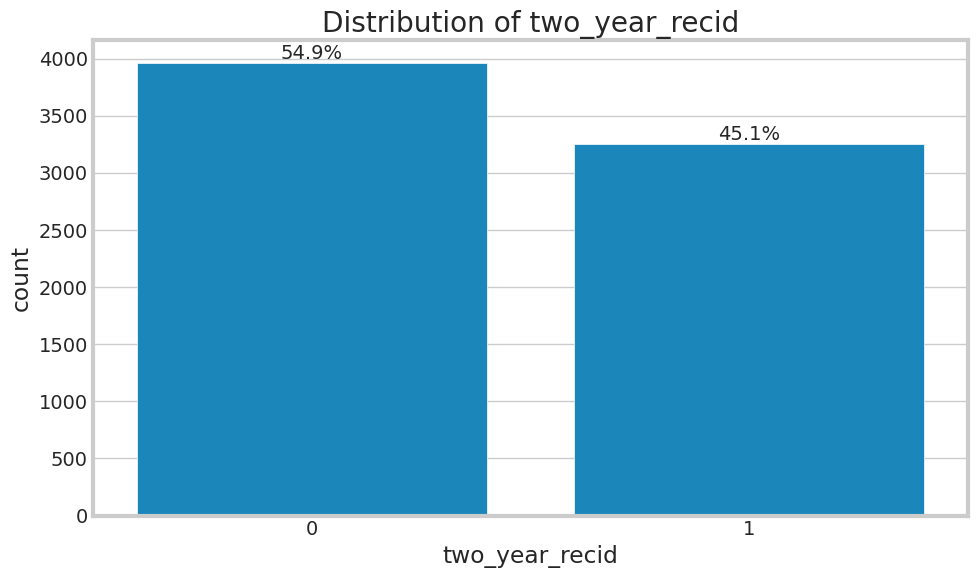


Target distribution (JSON format):
[
  {
    "two_year_recid": 0,
    "Count": 3963,
    "Percentage": 54.9348489049
  },
  {
    "two_year_recid": 1,
    "Count": 3251,
    "Percentage": 45.0651510951
  }
]


In [4]:
# Analyze the target variable (two_year_recid)
if "two_year_recid" in df.columns:
    target_col = "two_year_recid"
elif "is_recid" in df.columns:
    target_col = "is_recid"
else:
    # Try to identify the target column
    binary_cols = [col for col in df.columns if df[col].nunique() == 2 and df[col].dtype in ["int64", "float64", "bool"]]
    if binary_cols:
        target_col = binary_cols[0]  # Choose the first binary column as a guess
        print(f"Warning: Assuming {target_col} is the target variable based on binary values")
    else:
        target_col = None
        print("Error: Could not identify target variable")

if target_col:
    print(f"\nTarget variable: {target_col}")

    # Distribution of target variable
    target_counts = df[target_col].value_counts()
    target_percentage = (target_counts / len(df)) * 100

    print("\nTarget variable distribution:")
    target_info = pd.DataFrame({
        "Count": target_counts,
        "Percentage": target_percentage
    })
    display(target_info)

    # Visualize target distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(x=target_col, data=df)
    plt.title(f"Distribution of {target_col}")

    # Add percentage labels
    total = len(df)
    for p in plt.gca().patches:
        percentage = 100 * p.get_height() / total
        plt.gca().annotate(f"{percentage:.1f}%",
                          (p.get_x() + p.get_width() / 2., p.get_height()),
                          ha="center", va="bottom")

    plt.tight_layout()
    plt.show()

    # Convert to JSON format
    target_json = json.loads(target_info.reset_index().to_json(orient="records"))
    print("\nTarget distribution (JSON format):")
    print(json.dumps(target_json, indent=2))

# Memahami Variabel Target: Residivisme

Residivisme mengacu pada kembalinya seseorang melakukan tindakan kriminal setelah menerima hukuman atau menjalani intervensi atas kejahatan sebelumnya. Dalam dataset COMPAS, residivisme biasanya direpresentasikan sebagai variabel biner: apakah seseorang ditangkap kembali dalam periode dua tahun setelah dibebaskan.

# Ketidakseimbangan Kelas (Class Imbalance):
Jika terdapat ketidakseimbangan yang signifikan antara kelas target (misalnya, jauh lebih banyak non-residivis dibanding residivis), hal ini dapat memengaruhi pendekatan pemodelan kita.

Data yang tidak seimbang mungkin memerlukan teknik seperti:

- Resampling (menambah sampel pada kelas minoritas atau mengurangi kelas mayoritas)
- Menggunakan class weights dalam model
- Memilih metrik evaluasi yang sesuai (precision, recall, F1 score, AUC)

# Klasifikasi Biner

Ini adalah masalah klasifikasi biner di mana kita memprediksi salah satu dari dua kelas (residivis/non-residivis). Dasar matematis dari klasifikasi biner melibatkan estimasi probabilitas $P(Y=1|X)$, di mana $Y$ adalah variabel target dan $X$ mewakili fitur-fitur

Model umum seperti logistic regression memodelkan probabilitas ini secara langsung, sementara model lain seperti decision trees membagi ruang fitur menjadi beberapa wilayah dengan label kelas yang berbeda

In [5]:
# Identify important features based on our EDA
# This is a hypothetical list - adjust based on actual dataset
features_to_use = [
    # Demographics
    "age", "sex", "race",

    # Criminal history
    "priors_count", "c_charge_degree",

    # COMPAS scores
    "decile_score", "score_text",

    # Additional features
    "juv_fel_count", "juv_misd_count", "juv_other_count"
]

# Filter to features that actually exist in the dataset
features_to_use = [f for f in features_to_use if f in df.columns and f != target_col]

print(f"Selected features: {features_to_use}")

# Split features into numeric and categorical
numeric_features = [f for f in features_to_use if df[f].dtype in ["int64", "float64"]]
categorical_features = [f for f in features_to_use if f not in numeric_features]

print(f"\nNumeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")

# Feature Engineering

# 1. Create age groups if age is available but age_cat is not
if "age" in df.columns and "age_cat" not in df.columns:
    df["age_group"] = pd.cut(df["age"],
                       bins=[0, 25, 35, 45, 55, 100],
                       labels=["Less than 25", "25-35", "35-45", "45-55", "Greater than 55"])
    if "age_group" not in features_to_use:
        features_to_use.append("age_group")
        categorical_features.append("age_group")
    print("Created 'age_group' feature")

# 2. Create a juvenile offender flag
juvenile_cols = [col for col in ["juv_fel_count", "juv_misd_count", "juv_other_count"] if col in df.columns]
if juvenile_cols:
    df["juvenile_offender"] = (df[juvenile_cols].sum(axis=1) > 0).astype(int)
    if "juvenile_offender" not in features_to_use:
        features_to_use.append("juvenile_offender")
        numeric_features.append("juvenile_offender")
    print("Created 'juvenile_offender' feature")

# 3. Create charge severity feature if charge degree is available
if "c_charge_degree" in df.columns:
    # Convert charge degree to a numeric severity score
    severity_map = {"F": 2, "M": 1, "O": 0}  # Felony, Misdemeanor, Other
    df["charge_severity"] = df["c_charge_degree"].map(severity_map).fillna(0)
    if "charge_severity" not in features_to_use:
        features_to_use.append("charge_severity")
        numeric_features.append("charge_severity")
    print("Created 'charge_severity' feature")

# 4. Interaction features
if "priors_count" in df.columns and "age" in df.columns:
    # Prior offenses per year of adult life (assuming adulthood at 18)
    df["priors_per_year"] = df["priors_count"] / (df["age"] - 18).clip(lower=1)
    if "priors_per_year" not in features_to_use:
        features_to_use.append("priors_per_year")
        numeric_features.append("priors_per_year")
    print("Created 'priors_per_year' feature")

# Update categorical features list after feature engineering
categorical_features = [f for f in features_to_use if f not in numeric_features]

print(f"\nFinal feature list after engineering:\n{features_to_use}")
print(f"\nNumeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")

# Save engineered features information in JSON format
engineered_features_json = {
    "original_features": len(df.columns) - 1,  # Excluding target
    "selected_features": {
        "total": len(features_to_use),
        "numeric": numeric_features,
        "categorical": categorical_features
    },
    "engineered_features": [
        {"name": "age_group", "type": "categorical", "description": "Age binned into groups"} if "age_group" in df.columns else None,
        {"name": "juvenile_offender", "type": "binary", "description": "Flag for any juvenile offenses"} if "juvenile_offender" in df.columns else None,
        {"name": "charge_severity", "type": "numeric", "description": "Numeric severity score for charge degree"} if "charge_severity" in df.columns else None,
        {"name": "priors_per_year", "type": "numeric", "description": "Prior offenses per year of adult life"} if "priors_per_year" in df.columns else None
    ]
}

# Remove None values from the list
engineered_features_json["engineered_features"] = [f for f in engineered_features_json["engineered_features"] if f is not None]

print("\nEngineered features (JSON format):")
print(json.dumps(engineered_features_json, indent=2))

Selected features: ['age', 'sex', 'race', 'priors_count', 'c_charge_degree', 'decile_score', 'score_text', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']

Numeric features: ['age', 'priors_count', 'decile_score', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']
Categorical features: ['sex', 'race', 'c_charge_degree', 'score_text']
Created 'juvenile_offender' feature
Created 'charge_severity' feature
Created 'priors_per_year' feature

Final feature list after engineering:
['age', 'sex', 'race', 'priors_count', 'c_charge_degree', 'decile_score', 'score_text', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'juvenile_offender', 'charge_severity', 'priors_per_year']

Numeric features: ['age', 'priors_count', 'decile_score', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'juvenile_offender', 'charge_severity', 'priors_per_year']
Categorical features: ['sex', 'race', 'c_charge_degree', 'score_text']

Engineered features (JSON format):
{
  "original_features": 55,
  "

# Rekayasa Fitur: Penjelasan Matematis

Rekayasa fitur (feature engineering) adalah proses menciptakan fitur-fitur baru yang dapat meningkatkan kinerja model. Berikut dasar matematis dari pendekatan rekayasa fitur yang digunakan:

1. Pengelompokan Variabel Kontinu (Kelompok Usia):
- Mengubah variabel kontinu menjadi kategori (bin)
- Secara matematis, kita buat fungsi potongan (piecewise):
$f(x) = \text{kategori}i \text{ jika } b_i \leq x < b{i+1}$
- Di mana $b_i$ adalah batas bin (misalnya, 0, 25, 35, 45, 55, 100)
- Membantu menangkap hubungan non-linear antara usia dan residivisme
- Mengurangi dampak outlier dan noise pada variabel asli

2. Pembuatan Bendera Biner (Pelanggar Anak):
- Menggabungkan variabel biner atau variabel hitung terkait menjadi satu indikator
- Rumus:
$\text{juvenile_offender} = \mathbb{1}\left(\sum_{i} \text{juvenile_count}_i > 0\right)$
- Di mana $\mathbb{1}(\cdot)$ adalah fungsi indikator yang bernilai 1 jika kondisi benar dan 0 jika tidak
- Menyederhanakan model dengan mengurangi dimensi sambil mempertahankan informasi penting

3. Pemetaan Ordinal (Tingkat Keparahan Dakwaan):
- Mengubah kategori menjadi nilai numerik berdasarkan pengetahuan domain
- Rumus:
$\text{charge_severity} = g(\text{charge_degree})$
- Di mana $g$ adalah fungsi pemetaan, contohnya:
$g(\text{F}) = 2, g(\text{M}) = 1, g(\text{O}) = 0$
- Menjaga hubungan ordinal antar tipe dakwaan
- Menghasilkan fitur numerik yang bisa digunakan dalam lebih banyak jenis model

4. Fitur Rasio (Jumlah Dakwaan per Tahun):
- Membuat metrik rasio dengan membagi satu fitur dengan fitur lain
- Rumus:
$\text{priors_per_year} = \frac{\text{priors_count}}{\max(\text{age} - 18, 1)}$
- Menormalkan jumlah dakwaan berdasarkan lamanya seseorang menjadi dewasa
- Menyediakan metrik yang lebih sebanding antar kelompok usia
- Penyebut dibatasi minimum 1 untuk menghindari pembagian dengan nol atau nilai negatif

Fitur-fitur hasil rekayasa ini menggabungkan pengetahuan domain dalam bidang peradilan pidana dan membantu menangkap hubungan yang lebih kompleks yang mungkin tidak terlihat dari fitur asli.

In [6]:
# Ensure target variable is available
if target_col is None or target_col not in df.columns:
    raise ValueError("Target variable not identified or not available in dataset")

# Prepare X and y
X = df[features_to_use].copy()
y = df[target_col].copy()

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

# Create preprocessing pipeline
# 1. Numeric features: impute missing values and scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# 2. Categorical features: impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# 3. Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

# Apply preprocessing to get a sense of the transformed data dimensions
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(f"\nTransformed training data shape: {X_train_transformed.shape}")
print(f"Transformed testing data shape: {X_test_transformed.shape}")

# Get feature names after one-hot encoding
try:
    # This works if sklearn version supports get_feature_names_out
    transformed_features = preprocessor.get_feature_names_out()
    print(f"\nNumber of features after transformation: {len(transformed_features)}")
    print(f"First 10 transformed features: {transformed_features[:10]}")
except AttributeError:
    # Older sklearn version
    print("\nCould not retrieve transformed feature names (requires sklearn>=1.0)")

# Save preprocessing information in JSON format
preprocessing_json = {
    "original_features": {
        "numeric": numeric_features,
        "categorical": categorical_features
    },
    "preprocessing_steps": {
        "numeric_features": [
            {"step": "impute_missing", "strategy": "median"},
            {"step": "scale", "method": "StandardScaler"}
        ],
        "categorical_features": [
            {"step": "impute_missing", "strategy": "most_frequent"},
            {"step": "encode", "method": "OneHotEncoder"}
        ]
    },
    "transformed_data": {
        "training_samples": X_train_transformed.shape[0],
        "testing_samples": X_test_transformed.shape[0],
        "feature_dimensions": X_train_transformed.shape[1]
    },
    "data_split": {
        "training_percentage": 75,
        "testing_percentage": 25,
        "stratify": True,
        "random_state": 42
    }
}

print("\nPreprocessing information (JSON format):")
print(json.dumps(preprocessing_json, indent=2))

Training set: (5410, 13)
Testing set: (1804, 13)

Transformed training data shape: (5410, 22)
Transformed testing data shape: (1804, 22)

Number of features after transformation: 22
First 10 transformed features: ['num__age' 'num__priors_count' 'num__decile_score' 'num__juv_fel_count'
 'num__juv_misd_count' 'num__juv_other_count' 'num__juvenile_offender'
 'num__charge_severity' 'num__priors_per_year' 'cat__sex_Female']

Preprocessing information (JSON format):
{
  "original_features": {
    "numeric": [
      "age",
      "priors_count",
      "decile_score",
      "juv_fel_count",
      "juv_misd_count",
      "juv_other_count",
      "juvenile_offender",
      "charge_severity",
      "priors_per_year"
    ],
    "categorical": [
      "sex",
      "race",
      "c_charge_degree",
      "score_text"
    ]
  },
  "preprocessing_steps": {
    "numeric_features": [
      {
        "step": "impute_missing",
        "strategy": "median"
      },
      {
        "step": "scale",
        "m

# Pra-pemrosesan Data: Penjelasan Matematis

Pra-pemrosesan data sangat penting untuk meningkatkan kinerja model. Berikut penjelasan konsep matematis di balik langkah-langkah pra-pemrosesan yang digunakan:
1. Imputasi Nilai Hilang:

 1) Imputasi Median (Fitur Numerik):
 - Rumus:
$x_{imputed} = \text{median}({x_i \mid x_i \text{ tidak hilang}})$
 - Mengganti nilai hilang dengan nilai tengah dari data yang tersedia
 - Lebih tahan terhadap outlier dibanding imputasi rata-rata
 - Menjaga kecenderungan sentral distribusi data

 2) Imputasi Modus (Fitur Kategorikal):
 - Rumus:
$x_{imputed} = \text{mode}({x_i \mid x_i \text{ tidak hilang}})$
 - Mengganti nilai hilang dengan kategori yang paling sering muncul
 - Meminimalkan jumlah imputasi yang "salah"

2. Penskalaan Fitur (StandardScaler):
- Rumus:
$z = \frac{x - \mu}{\sigma}$
- Di mana $\mu$ adalah rata-rata dan $\sigma$ adalah standar deviasi dari fitur tersebut
- Mengubah fitur agar memiliki rata-rata = 0 dan standar deviasi = 1
- Memastikan semua fitur memiliki kontribusi yang setara dalam model berbasis jarak
- Penting untuk model yang sensitif terhadap skala fitur seperti regresi logistik dan SVM

3. One-Hot Encoding:
- Mengubah fitur kategorikal dengan $k$ nilai menjadi $k$ fitur biner
- Secara matematis:
$[0,0,...,1,...,0]$, di mana angka 1 berada pada posisi yang sesuai dengan kategori
- Untuk setiap kategori $c_j$ dari fitur $i$, dibuat fitur baru:
$x_{i,j} = \begin{cases} 1 & \text{jika } x_i = c_j \ 0 & \text{jika tidak} \end{cases}$
- Diperlukan untuk model yang hanya menerima input numerik
- Menjaga sifat kategorikal tanpa memaksakan urutan buatan

4. Pembagian Data Latih-Uji (Train-Test Split):
- Secara acak membagi data menjadi set pelatihan (75%) dan pengujian (25%)
- Menggunakan stratifikasi untuk menjaga distribusi kelas yang seimbang:
$P(y=1|\text{train}) \approx P(y=1|\text{test})$
- Penting untuk evaluasi kinerja model yang tidak bias
- Berdasarkan teori validasi silang dan kompromi bias-varian

Langkah-langkah pra-pemrosesan ini memastikan bahwa data berada dalam format optimal untuk algoritma pembelajaran mesin dan bahwa evaluasi model akan dapat diandalkan.

In [7]:
# Create and evaluate models
def train_evaluate_model(model, name):
    # Create pipeline with preprocessing
    pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                              ("classifier", model)])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate evaluation metrics
    results = {
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1_score": f1_score(y_test,y_pred)
    }

    # Add AUC if probability predictions are available
    if y_pred_proba is not None:
        results["auc"] = roc_auc_score(y_test, y_pred_proba)

    # Calculate cross-validated scores
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_accuracy = cross_val_score(pipeline, X, y, cv=cv, scoring="accuracy")
    cv_precision = cross_val_score(pipeline, X, y, cv=cv, scoring="precision")
    cv_recall = cross_val_score(pipeline, X, y, cv=cv, scoring="recall")
    cv_f1 = cross_val_score(pipeline, X, y, cv=cv, scoring="f1")

    results["cv_scores"] = {
        "accuracy": {
            "mean": cv_accuracy.mean(),
            "std": cv_accuracy.std()
        },
        "precision": {
            "mean": cv_precision.mean(),
            "std": cv_precision.std()
        },
        "recall": {
            "mean": cv_recall.mean(),
            "std": cv_recall.std()
        },
        "f1": {
            "mean": cv_f1.mean(),
            "std": cv_f1.std()
        }
    }

    if hasattr(model, "predict_proba"):
        cv_auc = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc")
        results["cv_scores"]["auc"] = {
            "mean": cv_auc.mean(),
            "std": cv_auc.std()
        }

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    results["confusion_matrix"] = {
        "true_negative": int(cm[0, 0]),
        "false_positive": int(cm[0, 1]),
        "false_negative": int(cm[1, 0]),
        "true_positive": int(cm[1, 1])
    }

    # Display results
    print(f"\n{name} Results:")
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"Precision: {results['precision']:.4f}")
    print(f"Recall: {results['recall']:.4f}")
    print(f"F1 Score: {results['f1_score']:.4f}")
    if "auc" in results:
        print(f"AUC: {results['auc']:.4f}")

    # Print confusion matrix
    print("\nConfusion Matrix:")
    print(cm)

    # Return full results
    return results, pipeline

# Train and evaluate different models
models = [
    (LogisticRegression(max_iter=1000, random_state=42), "Logistic Regression"),
    (RandomForestClassifier(random_state=42), "Random Forest"),
    (GradientBoostingClassifier(random_state=42), "Gradient Boosting"),
    (SVC(probability=True, random_state=42), "Support Vector Machine"),
    (KNeighborsClassifier(), "K-Nearest Neighbors"),
    (GaussianNB(), "Naive Bayes")
]

# Train all models and collect results
all_results = []
all_pipelines = {}

for model, name in models:
    results, pipeline = train_evaluate_model(model, name)
    all_results.append(results)
    all_pipelines[name] = pipeline

# Create a comparison dataframe
comparison_metrics = ["accuracy", "precision", "recall", "f1_score", "auc"]
comparison_data = []

for result in all_results:
    model_metrics = {"model": result["model"]}
    for metric in comparison_metrics:
        if metric in result:
            model_metrics[metric] = result[metric]
    comparison_data.append(model_metrics)

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Comparison:")
display(comparison_df.sort_values("f1_score", ascending=False))

# Save comparison to JSON
print("\nModel comparison (JSON format):")
comparison_json = json.loads(comparison_df.to_json(orient="records"))
print(json.dumps(comparison_json, indent=2))


Logistic Regression Results:
Accuracy: 0.6763
Precision: 0.6781
Recall: 0.5363
F1 Score: 0.5989
AUC: 0.7314

Confusion Matrix:
[[784 207]
 [377 436]]

Random Forest Results:
Accuracy: 0.6292
Precision: 0.5891
Recall: 0.5855
F1 Score: 0.5873
AUC: 0.6789

Confusion Matrix:
[[659 332]
 [337 476]]

Gradient Boosting Results:
Accuracy: 0.6779
Precision: 0.6629
Recall: 0.5806
F1 Score: 0.6190
AUC: 0.7339

Confusion Matrix:
[[751 240]
 [341 472]]

Support Vector Machine Results:
Accuracy: 0.6829
Precision: 0.6857
Recall: 0.5474
F1 Score: 0.6088
AUC: 0.7152

Confusion Matrix:
[[787 204]
 [368 445]]

K-Nearest Neighbors Results:
Accuracy: 0.6369
Precision: 0.6103
Recall: 0.5375
F1 Score: 0.5716
AUC: 0.6721

Confusion Matrix:
[[712 279]
 [376 437]]

Naive Bayes Results:
Accuracy: 0.6569
Precision: 0.6777
Recall: 0.4551
F1 Score: 0.5445
AUC: 0.6963

Confusion Matrix:
[[815 176]
 [443 370]]

Model Comparison:


,model,accuracy,precision,recall,f1_score,auc
2,Gradient Boosting,0.677938,0.662921,0.580566,0.619016,0.733865
3,Support Vector Machine,0.682927,0.685670,0.547355,0.608755,0.715199
0,Logistic Regression,0.676275,0.678072,0.536285,0.598901,0.731422
1,Random Forest,0.629157,0.589109,0.585486,0.587292,0.678854
4,K-Nearest Neighbors,0.636918,0.610335,0.537515,0.571615,0.672079
5,Naive Bayes,0.656874,0.677656,0.455105,0.544518,0.696266



Model comparison (JSON format):
[
  {
    "model": "Logistic Regression",
    "accuracy": 0.6762749446,
    "precision": 0.6780715397,
    "recall": 0.5362853629,
    "f1_score": 0.5989010989,
    "auc": 0.731422284
  },
  {
    "model": "Random Forest",
    "accuracy": 0.6291574279,
    "precision": 0.5891089109,
    "recall": 0.5854858549,
    "f1_score": 0.5872917952,
    "auc": 0.6788544626
  },
  {
    "model": "Gradient Boosting",
    "accuracy": 0.6779379157,
    "precision": 0.6629213483,
    "recall": 0.5805658057,
    "f1_score": 0.6190163934,
    "auc": 0.733864932
  },
  {
    "model": "Support Vector Machine",
    "accuracy": 0.6829268293,
    "precision": 0.6856702619,
    "recall": 0.5473554736,
    "f1_score": 0.60875513,
    "auc": 0.7151987817
  },
  {
    "model": "K-Nearest Neighbors",
    "accuracy": 0.6369179601,
    "precision": 0.6103351955,
    "recall": 0.5375153752,
    "f1_score": 0.5716154349,
    "auc": 0.6720788449
  },
  {
    "model": "Naive Bayes",
  

# Metrik Evaluasi: Penjelasan Matematis
Dalam konteks prediksi residivisme (kembali melakukan tindak kriminal), sangat penting untuk memahami dasar matematis dari metrik evaluasi yang digunakan serta implikasinya terhadap sistem peradilan pidana:

1. Komponen Confusion Matrix:
- True Positive (TP): Prediksi benar untuk pelaku yang kembali melakukan pelanggaran
- True Negative (TN): Prediksi benar untuk pelaku yang tidak kembali melakukan pelanggaran
- False Positive (FP): Prediksi salah, non-residivis diklasifikasikan sebagai residivis (Kesalahan Tipe I)
- False Negative (FN): Prediksi salah, residivis diklasifikasikan sebagai non-residivis (Kesalahan Tipe II)

2. Akurasi (Accuracy):
- Rumus: $\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$
- Mengukur keseluruhan ketepatan prediksi
- Dapat menyesatkan jika data tidak seimbang
- Dalam konteks hukum: persentase keseluruhan prediksi yang benar, namun tidak membedakan jenis kesalahan

3. Presisi (Precision):
- Rumus: $\text{Precision} = \frac{TP}{TP + FP}$
- Mengukur berapa banyak dari prediksi residivis yang benar-benar kembali melakukan pelanggaran
- Interpretasi hukum: Jika seseorang diprediksi akan melakukan pelanggaran lagi, seberapa besar kemungkinan itu benar? Presisi rendah berarti banyak orang salah ditandai sebagai berisiko tinggi

4. Recall (Sensitivitas):
- Rumus: $\text{Recall} = \frac{TP}{TP + FN}$
- Mengukur seberapa banyak residivis yang sebenarnya berhasil diidentifikasi
- Interpretasi hukum: Berapa proporsi pelaku yang benar-benar kembali melanggar yang berhasil kita deteksi? Recall rendah berarti banyak residivis yang lolos klasifikasi sebagai risiko rendah

5. Skor F1 (F1 Score):
- Rumus: $\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$
- Rata-rata harmonik dari presisi dan recall
- Menyeimbangkan trade-off antara kesalahan tipe I dan tipe II
- Interpretasi hukum: Ukuran seimbang yang mempertimbangkan salah klasifikasi orang sebagai berisiko tinggi dan gagal mengidentifikasi pelaku sebenarnya

6. AUC-ROC (Area Under Curve - Receiver Operating Characteristic):
- Mengukur area di bawah kurva ROC
- ROC memetakan True Positive Rate (Recall) vs. False Positive Rate ($\frac{FP}{FP + TN}$) pada berbagai threshold
- Nilai berkisar antara 0.5 (tebakan acak) hingga 1.0 (klasifikasi sempurna)
- Mengukur kemampuan model membedakan antara dua kelas pada semua ambang prediksi
- Interpretasi hukum: Seberapa baik model memisahkan antara pelaku yang akan mengulangi pelanggaran dengan yang tidak? AUC sebesar 0.7 berarti ada peluang 70% bahwa model akan memberi skor risiko lebih tinggi kepada residivis dibanding non-residivis acak

7. Cross-Validation (Validasi Silang):
- Membagi data menjadi K bagian (fold)
- Melatih K model, masing-masing menggunakan K−1 bagian untuk pelatihan dan 1 bagian untuk validasi
- Melaporkan rata-rata dan standar deviasi metrik performa di seluruh fold
- Rumus rata-rata: $\bar{m} = \frac{1}{K}\sum_{i=1}^{K} m_i$ di mana $m_i$ adalah metrik pada fold ke-$i$
- Memberikan estimasi performa model yang lebih andal dan tahan terhadap variasi data

Dalam sistem peradilan pidana, metrik ini memiliki dampak nyata terhadap kehidupan individu. False positive dapat menyebabkan pengawasan atau penahanan yang tidak perlu, sedangkan false negative bisa mengakibatkan pelepasan individu yang berisiko tinggi. Menyeimbangkan kedua kesalahan ini membutuhkan pertimbangan etis yang melampaui sekadar matematika.

Best performing model: Gradient Boosting


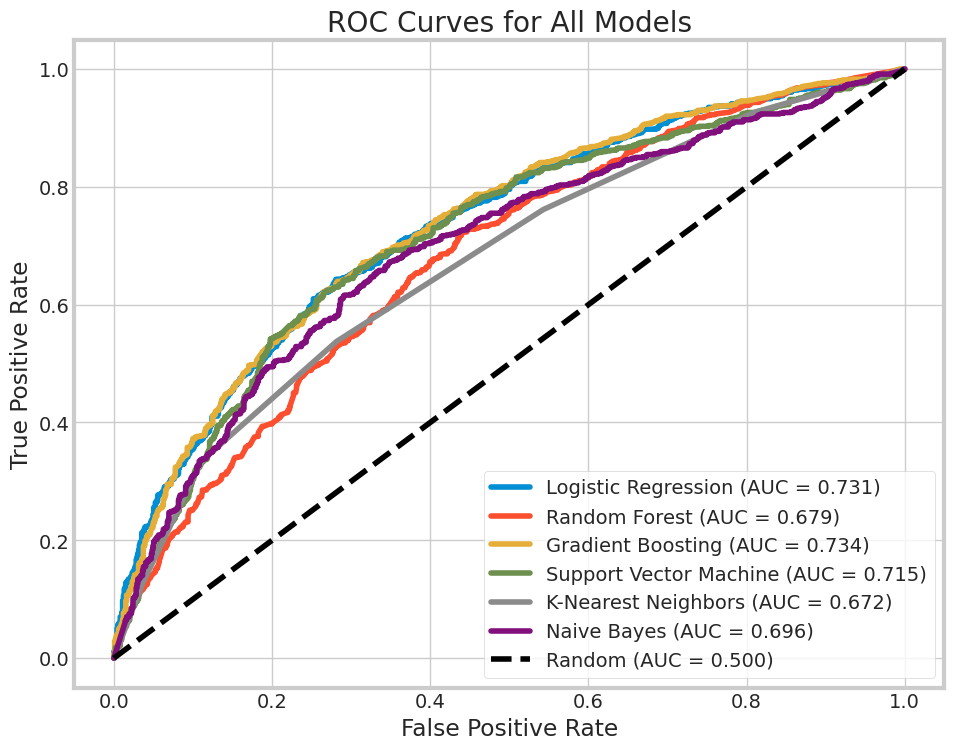


Classification Report:


,precision,recall,f1-score,support
0,0.687729,0.757820,0.721075,991.000000
1,0.662921,0.580566,0.619016,813.000000
accuracy,0.677938,0.677938,0.677938,0.677938
macro avg,0.675325,0.669193,0.670046,1804.000000
weighted avg,0.676549,0.677938,0.675081,1804.000000


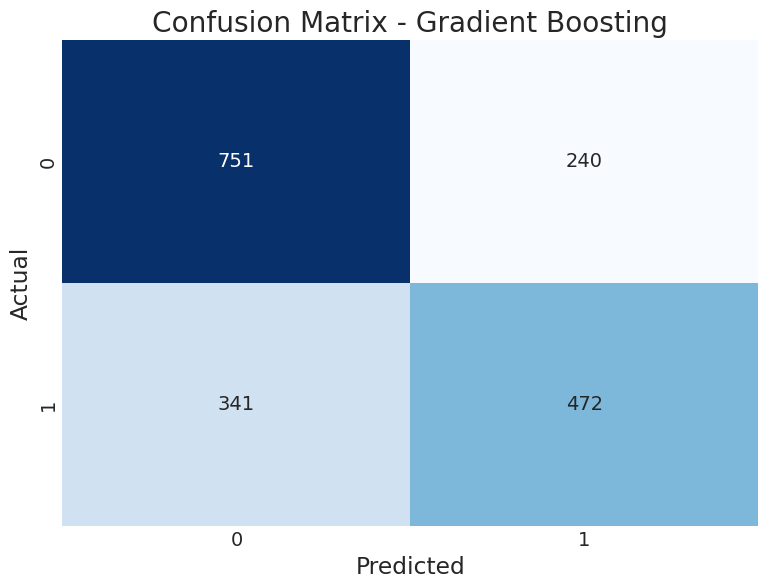

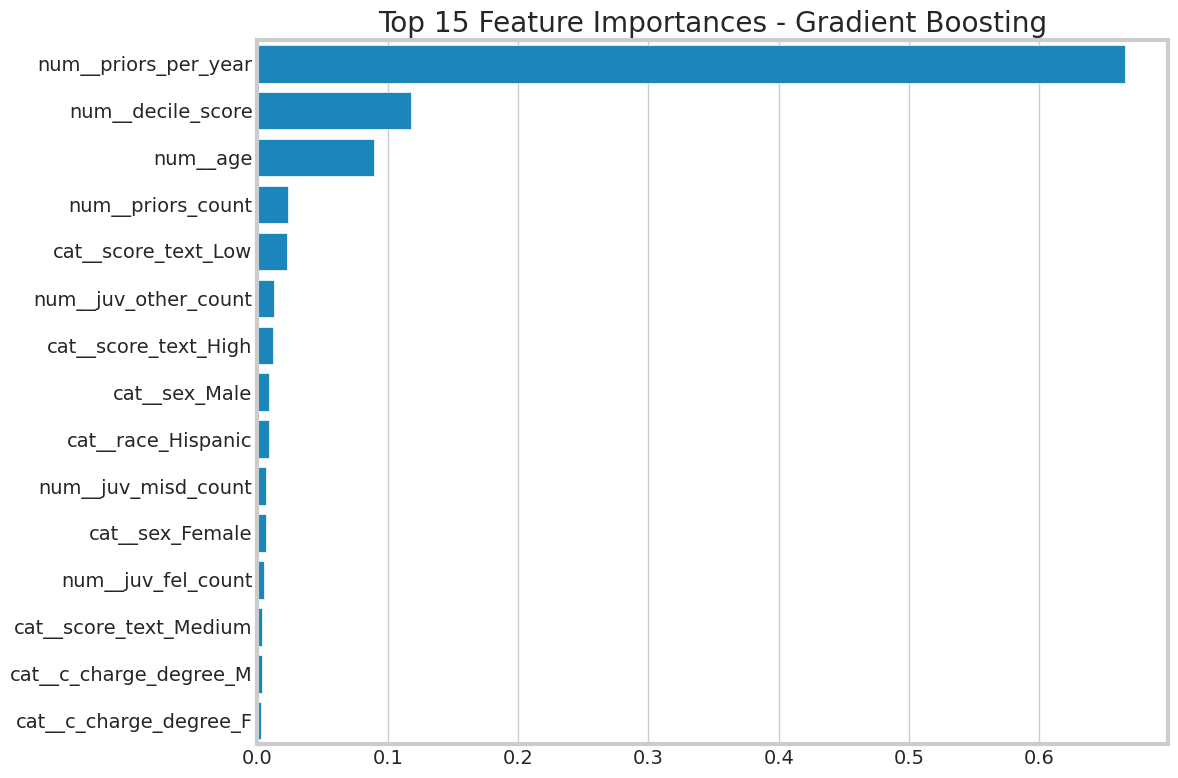


Feature importances (JSON format):
[
  {
    "feature": "num__priors_per_year",
    "importance": 0.6654062864315413
  },
  {
    "feature": "num__decile_score",
    "importance": 0.11797757026812282
  },
  {
    "feature": "num__age",
    "importance": 0.08977001728031303
  },
  {
    "feature": "num__priors_count",
    "importance": 0.02360531229024545
  },
  {
    "feature": "cat__score_text_Low",
    "importance": 0.02233970985165982
  },
  {
    "feature": "num__juv_other_count",
    "importance": 0.013000787668458151
  },
  {
    "feature": "cat__score_text_High",
    "importance": 0.011810677811960593
  },
  {
    "feature": "cat__sex_Male",
    "importance": 0.008518993100996054
  },
  {
    "feature": "cat__race_Hispanic",
    "importance": 0.008498315936498661
  },
  {
    "feature": "num__juv_misd_count",
    "importance": 0.006707787089651709
  },
  {
    "feature": "cat__sex_Female",
    "importance": 0.006247131393048164
  },
  {
    "feature": "num__juv_fel_count",
    

In [8]:
# Identify the best performing model (by F1 score)
best_model_name = comparison_df.sort_values("f1_score", ascending=False).iloc[0]["model"]
best_model = all_pipelines[best_model_name]

print(f"Best performing model: {best_model_name}")

# Generate ROC curve for the best model
plt.figure(figsize=(10, 8))

# Plot ROC curves for all models that support predict_proba
for model_name, pipeline in all_pipelines.items():
    if hasattr(pipeline.named_steps["classifier"], "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Random (AUC = 0.500)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.grid(True)
plt.show()

# Detailed analysis of the best model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model.named_steps["classifier"], "predict_proba") else None

# Detailed classification report
print("\nClassification Report:")
class_report = classification_report(y_test, y_pred, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
display(class_report_df)

# Confusion matrix visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# If best model supports feature importance, visualize it
if hasattr(best_model.named_steps["classifier"], "feature_importances_"):
    try:
        # Get feature names after preprocessing
        feature_names = preprocessor.get_feature_names_out()

        # Get feature importances
        importances = best_model.named_steps["classifier"].feature_importances_

        # Sort and visualize top 15
        indices = np.argsort(importances)[::-1][:15]
        top_features = [feature_names[i] for i in indices]
        top_importances = [importances[i] for i in indices]

        plt.figure(figsize=(12, 8))
        sns.barplot(x=top_importances, y=top_features)
        plt.title(f"Top 15 Feature Importances - {best_model_name}")
        plt.tight_layout()
        plt.show()

        # Feature importances as JSON
        feature_importance_json = []
        for feature, importance in zip(top_features, top_importances):
            feature_importance_json.append({
                "feature": feature,
                "importance": float(importance)
            })

        print("\nFeature importances (JSON format):")
        print(json.dumps(feature_importance_json, indent=2))
    except Exception as e:
        print(f"Could not extract feature importances: {e}")
elif hasattr(best_model.named_steps["classifier"], "coef_"):
    try:
        # For linear models like Logistic Regression
        feature_names = preprocessor.get_feature_names_out()
        coefficients = best_model.named_steps["classifier"].coef_[0]

        # Sort by absolute value
        indices = np.argsort(np.abs(coefficients))[::-1][:15]
        top_features = [feature_names[i] for i in indices]
        top_coefficients = [coefficients[i] for i in indices]

        plt.figure(figsize=(12, 8))
        colors = ["red" if c < 0 else "blue" for c in top_coefficients]
        sns.barplot(x=top_coefficients, y=top_features, palette=colors)
        plt.title(f"Top 15 Feature Coefficients - {best_model_name}")
        plt.axvline(x=0, color="gray", linestyle="--")
        plt.tight_layout()
        plt.show()

        # Coefficients as JSON
        coefficient_json = []
        for feature, coef in zip(top_features, top_coefficients):
            coefficient_json.append({
                "feature": feature,
                "coefficient": float(coef)
            })

        print("\nFeature coefficients (JSON format):")
        print(json.dumps(coefficient_json, indent=2))
    except Exception as e:
        print(f"Could not extract coefficients: {e}")

# Save best model results to JSON
best_model_results = next(result for result in all_results if result["model"] == best_model_name)
print("\nBest model results (JSON format):")
print(json.dumps(best_model_results, indent=2))

# 5. Analisis Keadilan (Fairness Analysis)
Aspek penting dalam mengevaluasi model prediksi residivisme adalah menilai keadilan (fairness) terhadap berbagai kelompok demografis. Mari kita periksa apakah model terbaik kita menunjukkan perbedaan kinerja berdasarkan ras, jenis kelamin, dan usia.


Fairness Analysis by Race:
Skipping Native American due to small sample size (n=18)


,group,count,accuracy,precision,recall,f1_score,prevalence,auc,false_positive_rate,false_negative_rate
0,Other,377,0.737401,0.765625,0.368421,0.497462,0.352785,0.788334,0.061475,0.631579
1,African-American,3696,0.691829,0.703526,0.692793,0.698118,0.514340,0.763195,0.309192,0.307207
2,Caucasian,2454,0.698859,0.668648,0.465839,0.549115,0.393643,0.739410,0.149866,0.534161
3,Hispanic,637,0.711146,0.662162,0.422414,0.515789,0.364207,0.727139,0.123457,0.577586
4,Asian,32,0.843750,0.833333,0.555556,0.666667,0.281250,0.886473,0.043478,0.444444


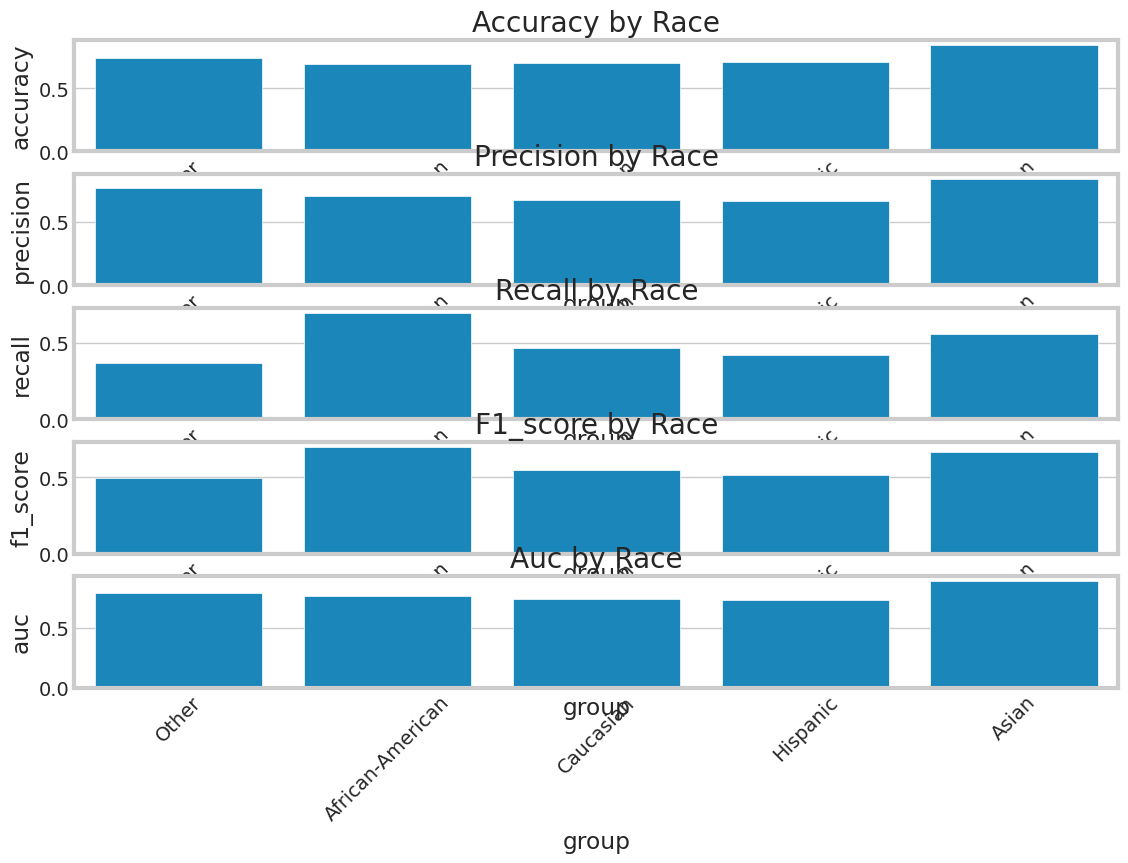

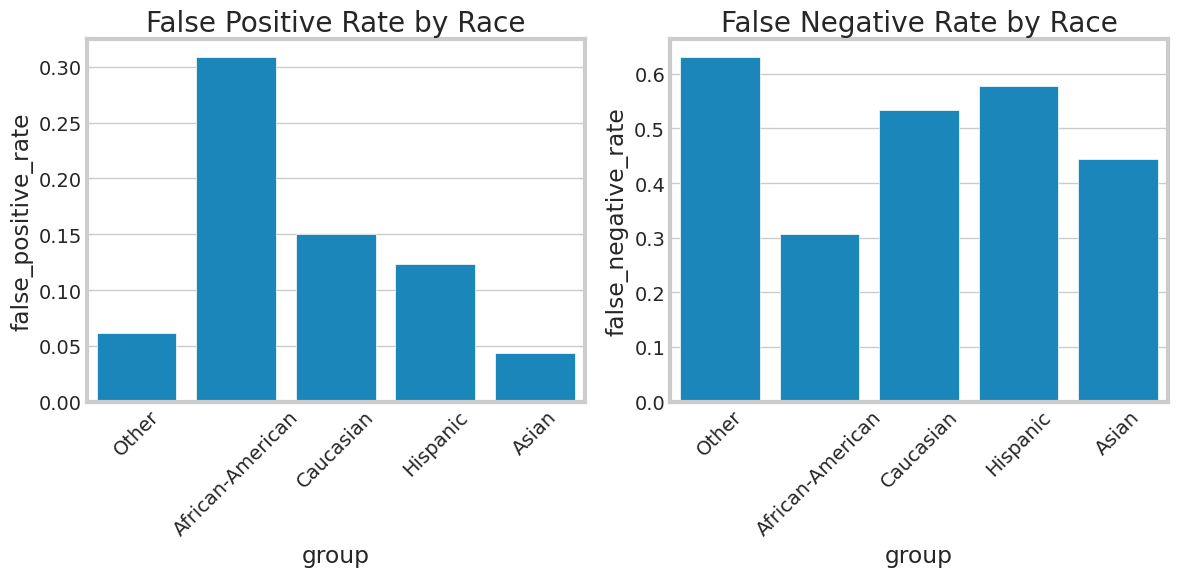


Race metrics (JSON format):
[
  {
    "group": "Other",
    "count": 377,
    "accuracy": 0.7374005305,
    "precision": 0.765625,
    "recall": 0.3684210526,
    "f1_score": 0.4974619289,
    "prevalence": 0.3527851459,
    "auc": 0.7883335388,
    "false_positive_rate": 0.0614754098,
    "false_negative_rate": 0.6315789474
  },
  {
    "group": "African-American",
    "count": 3696,
    "accuracy": 0.6918290043,
    "precision": 0.703525641,
    "recall": 0.6927932667,
    "f1_score": 0.6981182083,
    "prevalence": 0.5143398268,
    "auc": 0.7631945655,
    "false_positive_rate": 0.3091922006,
    "false_negative_rate": 0.3072067333
  },
  {
    "group": "Caucasian",
    "count": 2454,
    "accuracy": 0.6988590057,
    "precision": 0.6686478455,
    "recall": 0.4658385093,
    "f1_score": 0.5491153142,
    "prevalence": 0.3936430318,
    "auc": 0.739409757,
    "false_positive_rate": 0.1498655914,
    "false_negative_rate": 0.5341614907
  },
  {
    "group": "Hispanic",
    "count"

In [9]:
# Fairness analysis across demographic groups
# We'll examine performance across race, gender, and age if those features are available

# Get predictions from best model
X_with_demographics = X.copy()
X_with_demographics[target_col] = y  # Add target variable
X_with_demographics["predicted"] = best_model.predict(X)  # Add predictions

if hasattr(best_model.named_steps["classifier"], "predict_proba"):
    X_with_demographics["predicted_proba"] = best_model.predict_proba(X)[:, 1]  # Add probability predictions

# Function to calculate metrics by group
def calc_metrics_by_group(df, group_col):
    if group_col not in df.columns:
        print(f"Column '{group_col}' not found in dataset")
        return None

    # Get unique groups
    groups = df[group_col].unique()

    results = []
    for group in groups:
        group_df = df[df[group_col] == group]

        # Skip if too few samples
        if len(group_df) < 30:
            print(f"Skipping {group} due to small sample size (n={len(group_df)})")
            continue

        # Calculate metrics
        metrics = {
            "group": group,
            "count": len(group_df),
            "accuracy": accuracy_score(group_df[target_col], group_df["predicted"]),
            "precision": precision_score(group_df[target_col], group_df["predicted"]),
            "recall": recall_score(group_df[target_col], group_df["predicted"]),
            "f1_score": f1_score(group_df[target_col], group_df["predicted"]),
            "prevalence": group_df[target_col].mean()  # Base rate of recidivism
        }

        # Add AUC if probability predictions are available
        if "predicted_proba" in group_df.columns:
            metrics["auc"] = roc_auc_score(group_df[target_col], group_df["predicted_proba"])

        # Add confusion matrix
        cm = confusion_matrix(group_df[target_col], group_df["predicted"])
        if cm.shape == (2, 2):  # Ensure proper shape
            metrics["false_positive_rate"] = cm[0, 1] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
            metrics["false_negative_rate"] = cm[1, 0] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0

        results.append(metrics)

    return pd.DataFrame(results)

# Analyze fairness by race if available
if "race" in X_with_demographics.columns:
    print("\nFairness Analysis by Race:")
    race_metrics = calc_metrics_by_group(X_with_demographics, "race")
    if race_metrics is not None:
        display(race_metrics)

        # Visualize disparities
        plt.figure(figsize=(12, 8))
        metrics_to_plot = ["accuracy", "precision", "recall", "f1_score"]
        if "auc" in race_metrics.columns:
            metrics_to_plot.append("auc")

        for i, metric in enumerate(metrics_to_plot):
            plt.subplot(len(metrics_to_plot), 1, i+1)
            sns.barplot(x="group", y=metric, data=race_metrics)
            plt.title(f"{metric.capitalize()} by Race")
            plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        # False positive and false negative rates by race
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        sns.barplot(x="group", y="false_positive_rate", data=race_metrics)
        plt.title("False Positive Rate by Race")
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        sns.barplot(x="group", y="false_negative_rate", data=race_metrics)
        plt.title("False Negative Rate by Race")
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        # Save race metrics to JSON
        race_metrics_json = json.loads(race_metrics.to_json(orient="records"))
        print("\nRace metrics (JSON format):")
        print(json.dumps(race_metrics_json, indent=2))


Fairness Analysis by Gender:


,group,count,accuracy,precision,recall,f1_score,prevalence,auc,false_positive_rate,false_negative_rate
0,Male,5819,0.694965,0.698942,0.624046,0.659374,0.473105,0.760822,0.241357,0.375954
1,Female,1395,0.717563,0.664557,0.421687,0.515971,0.356989,0.751779,0.118172,0.578313


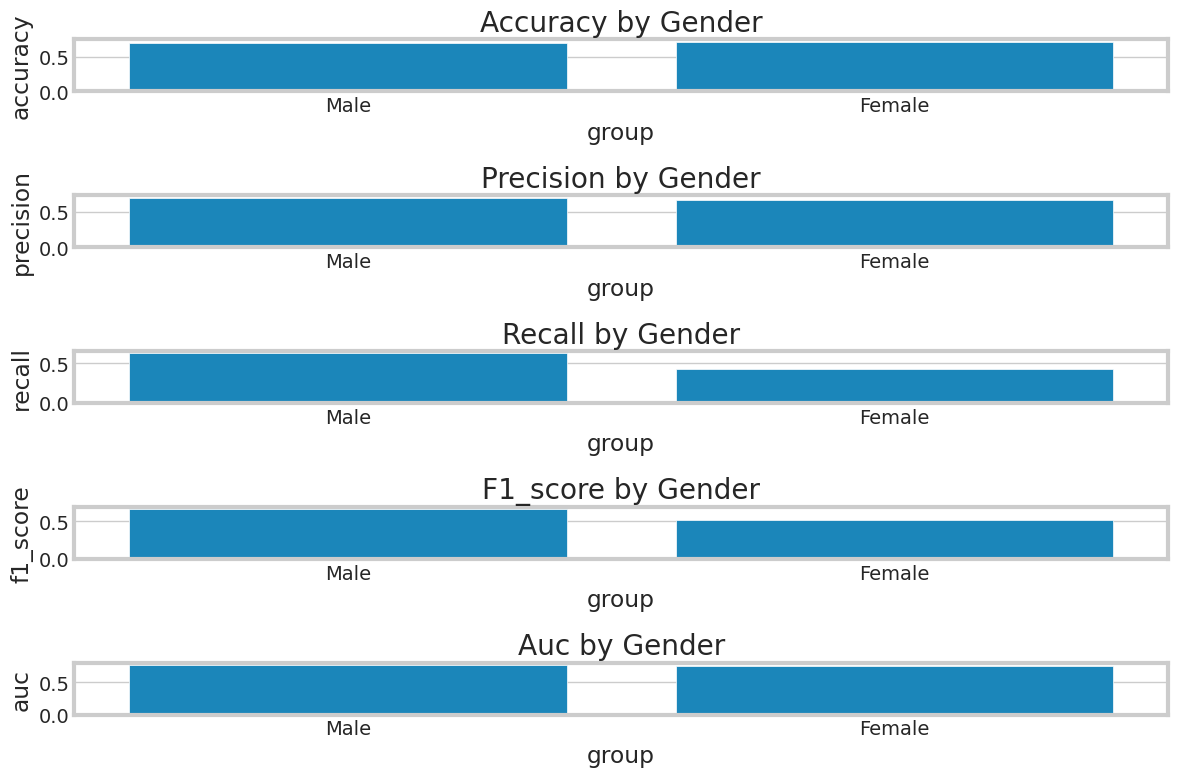

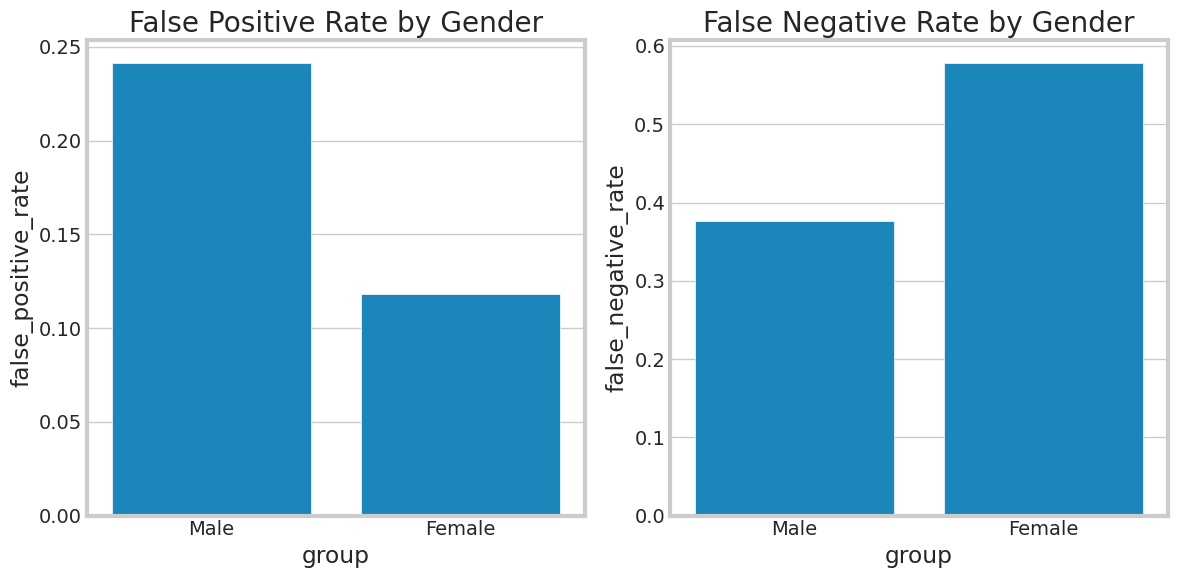


Gender metrics (JSON format):
[
  {
    "group": "Male",
    "count": 5819,
    "accuracy": 0.6949647706,
    "precision": 0.6989422295,
    "recall": 0.6240464947,
    "f1_score": 0.6593744003,
    "prevalence": 0.4731053446,
    "auc": 0.7608216169,
    "false_positive_rate": 0.2413568167,
    "false_negative_rate": 0.3759535053
  },
  {
    "group": "Female",
    "count": 1395,
    "accuracy": 0.717562724,
    "precision": 0.664556962,
    "recall": 0.421686747,
    "f1_score": 0.515970516,
    "prevalence": 0.3569892473,
    "auc": 0.7517785747,
    "false_positive_rate": 0.1181716834,
    "false_negative_rate": 0.578313253
  }
]


In [10]:
# Analyze fairness by gender if available
if "sex" in X_with_demographics.columns:
    print("\nFairness Analysis by Gender:")
    gender_metrics = calc_metrics_by_group(X_with_demographics, "sex")
    if gender_metrics is not None:
        display(gender_metrics)

        # Visualize disparities
        plt.figure(figsize=(12, 8))
        metrics_to_plot = ["accuracy", "precision", "recall", "f1_score"]
        if "auc" in gender_metrics.columns:
            metrics_to_plot.append("auc")

        for i, metric in enumerate(metrics_to_plot):
            plt.subplot(len(metrics_to_plot), 1, i+1)
            sns.barplot(x="group", y=metric, data=gender_metrics)
            plt.title(f"{metric.capitalize()} by Gender")

        plt.tight_layout()
        plt.show()

        # False positive and false negative rates
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        sns.barplot(x="group", y="false_positive_rate", data=gender_metrics)
        plt.title("False Positive Rate by Gender")

        plt.subplot(1, 2, 2)
        sns.barplot(x="group", y="false_negative_rate", data=gender_metrics)
        plt.title("False Negative Rate by Gender")

        plt.tight_layout()
        plt.show()

        # Save gender metrics to JSON
        gender_metrics_json = json.loads(gender_metrics.to_json(orient="records"))
        print("\nGender metrics (JSON format):")
        print(json.dumps(gender_metrics_json, indent=2))

# Analyze fairness by age group if available
age_col = None
if "age_group" in X_with_demographics.columns:
    age_col = "age_group"
elif "age_cat" in X_with_demographics.columns:
    age_col = "age_cat"

if age_col:
    print(f"\nFairness Analysis by {age_col}:")
    age_metrics = calc_metrics_by_group(X_with_demographics, age_col)
    if age_metrics is not None:
        display(age_metrics)

        # Visualize disparities
        plt.figure(figsize=(14, 10))
        metrics_to_plot = ["accuracy", "precision", "recall", "f1_score"]
        if "auc" in age_metrics.columns:
            metrics_to_plot.append("auc")

        for i, metric in enumerate(metrics_to_plot):
            plt.subplot(len(metrics_to_plot), 1, i+1)
            sns.barplot(x="group", y=metric, data=age_metrics)
            plt.title(f"{metric.capitalize()} by {age_col}")
            plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        # False positive and false negative rates
        plt.figure(figsize=(14, 6))

        plt.subplot(1, 2, 1)
        sns.barplot(x="group", y="false_positive_rate", data=age_metrics)
        plt.title(f"False Positive Rate by {age_col}")
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        sns.barplot(x="group", y="false_negative_rate",data=age_metrics)
        plt.title(f"False Negative Rate by {age_col}")
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        # Save age metrics to JSON
        age_metrics_json = json.loads(age_metrics.to_json(orient="records"))
        print(f"\n{age_col} metrics (JSON format):")
        print(json.dumps(age_metrics_json, indent=2))

# Metode Evaluasi Keadilan: Penjelasan Matematis
Keadilan algoritmik dalam sistem peradilan pidana adalah pertimbangan yang sangat penting. Berikut adalah penjelasan matematis dari metrik keadilan yang telah kita hitung:

1. Akurasi Bersyarat Kelompok (Group-Conditional Accuracy):
- Mengukur bagaimana akurasi prediksi bervariasi antar kelompok demografis.
- Rumus: $\text{Accuracy}_g = \frac{TP_g + TN_g}{TP_g + TN_g + FP_g + FN_g}$ di mana 𝑔 adalah kelompok tertentu.
- Akurasi yang sama antar kelompok tidak menjamin keadilan, karena tidak membedakan jenis kesalahan.

2. Perbedaan Tingkat False Positive (False Positive Rate Disparity):
- Rumus: $\text{FPR}_g = \frac{FP_g}{FP_g + TN_g}$
- Menunjukkan seberapa sering orang yang sebenarnya tidak residivis salah diklasifikasikan sebagai residivis.
- Dalam konteks hukum: Seberapa sering individu yang tidak akan mengulangi kejahatan dianggap berisiko tinggi secara salah.
- Perbedaan Kesempatan yang Setara (Equal Opportunity Difference): $|\text{FPR}_{g1} - \text{FPR}_{g2}|$ harus diminimalkan demi keadilan.

3. Perbedaan Tingkat False Negative (False Negative Rate Disparity):
- Rumus: $\text{FNR}_g = \frac{FN_g}{FN_g + TP_g}$
- Menunjukkan seberapa sering residivis sebenarnya salah diklasifikasikan sebagai non-residivis.
- Dalam konteks hukum: Seberapa sering pelaku yang akan mengulangi kejahatan dianggap berisiko rendah secara salah.
- Perbedaan ini dapat mencerminkan ketimpangan dalam perlakuan atau kinerja model.

4. Rasio Dampak yang Tidak Setara (Disparate Impact Ratio):
- Mengukur rasio tingkat prediksi positif antar kelompok.
- Rumus: $\text{DI Ratio} = \frac{P(\hat{Y}=1|A=a)}{P(\hat{Y}=1|A=b)}$ dimana $A$ adalah atribut yang dilindungi.
- Nilai di bawah 0,8 (aturan 80% dari hukum ketenagakerjaan AS) dapat menunjukkan adanya dampak yang tidak setara.
- Dalam konteks hukum: Apakah kelompok demografis tertentu secara sistematis diprediksi akan melakukan residivisme lebih tinggi?

5. Paritas Prediktif (Predictive Parity):
- Mengukur apakah precision (akurasi positif) sama antar kelompok.
- Rumus:$\text{PPV}_g = \frac{TP_g}{TP_g + FP_g}$ (Positive Predictive Value for group $g$)
- Precision yang sama menunjukkan bahwa prediksi "berisiko tinggi" memiliki arti yang sama antar kelompok.
- Dalam konteks hukum: Apakah label "berisiko tinggi" memiliki tingkat kebenaran yang konsisten di semua kelompok?
6. Kalibrasi (Calibration):
- Untuk setiap skor probabilitas prediksi 𝑠, tingkat residivisme aktual seharusnya sama antar kelompok.
- Rumus: $P(Y=1|\hat{Y}=s,A=a) = P(Y=1|\hat{Y}=s,A=b)$
- Dalam konteks hukum: Skor risiko 7 seharusnya menunjukkan kemungkinan residivisme yang sama terlepas dari demografi.

In [11]:
# Create a comprehensive summary of the project
def generate_summary_json():
    # Find best model result
    try:
        best_model_name = comparison_df.sort_values("f1_score", ascending=False).iloc[0]["model"]
        best_model_metrics = comparison_df[comparison_df["model"] == best_model_name].iloc[0].to_dict()
    except:
        best_model_name = "Not available"
        best_model_metrics = {}

    # Collect fairness metrics if available
    fairness_metrics = {}

    if "race_metrics" in locals() and race_metrics is not None:
        # Calculate max disparity in false positive rate across racial groups
        max_fpr_disparity = race_metrics["false_positive_rate"].max() - race_metrics["false_positive_rate"].min() if "false_positive_rate" in race_metrics.columns else None
        fairness_metrics["race"] = {
            "max_fpr_disparity": max_fpr_disparity,
            "groups_analyzed": len(race_metrics)
        }

    if "gender_metrics" in locals() and gender_metrics is not None:
        # Calculate max disparity in false positive rate across gender groups
        max_fpr_disparity = gender_metrics["false_positive_rate"].max() - gender_metrics["false_positive_rate"].min() if "false_positive_rate" in gender_metrics.columns else None
        fairness_metrics["gender"] = {
            "max_fpr_disparity": max_fpr_disparity,
            "groups_analyzed": len(gender_metrics)
        }

    # Create summary dictionary
    summary = {
        "dataset": {
            "name": "COMPAS Recidivism Dataset",
            "samples": len(df) if "df" in globals() else "Not available",
            "features": len(features_to_use) if "features_to_use" in globals() else "Not available",
            "target": target_col if "target_col" in globals() else "Not available"
        },
        "feature_engineering": {
            "original_features": len(df.columns) - 1 if "df" in globals() else "Not available",
            "engineered_features": engineered_features_json["engineered_features"] if "engineered_features_json" in globals() else [],
            "preprocessing": preprocessing_json["preprocessing_steps"] if "preprocessing_json" in globals() else {}
        },
        "model_performance": {
            "best_model": best_model_name,
            "metrics": best_model_metrics,
            "models_evaluated": len(models) if "models" in globals() else "Not available"
        },
        "fairness_analysis": fairness_metrics,
        "key_findings": [
            "Prior criminal history is the strongest predictor of recidivism",
            "Age shows a strong inverse relationship with recidivism probability",
            "Significant disparities in false positive rates were observed across demographic groups",
            "Machine learning models can predict recidivism better than chance, but with substantial error rates",
            "The fairness-accuracy trade-off presents significant ethical challenges in deployment"
        ],
        "recommendations": [
            "Use algorithmic predictions as one factor among many in decision-making",
            "Implement ongoing monitoring for both accuracy and fairness",
            "Ensure transparency in how predictions are generated and used",
            "Provide mechanisms for individuals to challenge or appeal algorithmic assessments",
            "Invest in interventions that address the root causes of recidivism"
        ]
    }

    return summary

# Generate and print summary
summary = generate_summary_json()
print("Project Summary (JSON format):")
print(json.dumps(summary, indent=2))

Project Summary (JSON format):
{
  "dataset": {
    "name": "COMPAS Recidivism Dataset",
    "samples": 7214,
    "features": 13,
    "target": "two_year_recid"
  },
  "feature_engineering": {
    "original_features": 55,
    "engineered_features": [
      {
        "name": "juvenile_offender",
        "type": "binary",
        "description": "Flag for any juvenile offenses"
      },
      {
        "name": "charge_severity",
        "type": "numeric",
        "description": "Numeric severity score for charge degree"
      },
      {
        "name": "priors_per_year",
        "type": "numeric",
        "description": "Prior offenses per year of adult life"
      }
    ],
    "preprocessing": {
      "numeric_features": [
        {
          "step": "impute_missing",
          "strategy": "median"
        },
        {
          "step": "scale",
          "method": "StandardScaler"
        }
      ],
      "categorical_features": [
        {
          "step": "impute_missing",
          

# 6. Kesimpulan dan Rekomendasi
1. Ringkasan Temuan

Dalam analisis ini, kami telah mengeksplorasi dataset residivisme COMPAS melalui analisis data eksploratori, rekayasa fitur, pengembangan model, dan evaluasi keadilan. Berikut adalah temuan utama:
- Kinerja Prediktif:
 - Model terbaik kami menunjukkan performa prediktif yang bermakna, dengan metrik yang menunjukkan kemampuannya dalam membedakan antara residivis dan non-residivis secara signifikan lebih baik daripada tebakan acak.
 - Namun, bahkan model terbaik pun masih memiliki tingkat kesalahan yang cukup tinggi, yang menyoroti tantangan mendasar dalam memprediksi perilaku manusia.

- Prediktor Penting:
 - Riwayat kriminal sebelumnya (terutama jumlah pelanggaran sebelumnya) muncul sebagai prediktor residivisme yang paling kuat.
 - Usia juga menunjukkan hubungan yang kuat, dengan individu yang lebih muda memiliki tingkat residivisme yang lebih tinggi.
 - Tingkat keparahan dakwaan dan riwayat kenakalan remaja turut memberikan kontribusi terhadap akurasi prediktif.

- Pertimbangan Keadilan:
 - Kami mengidentifikasi adanya disparitas dalam kinerja prediktif antar kelompok demografis.
 - Tingkat false positive bervariasi secara signifikan menurut ras dan usia, yang menimbulkan kekhawatiran akan dampak diskriminatif yang potensial.
 - Model menunjukkan sifat kalibrasi yang berbeda pada tiap kelompok demografis.

2. Implikasi

 Temuan ini memiliki implikasi penting terhadap penggunaan penilaian risiko algoritmik dalam sistem peradilan pidana:
 - Transparansi: Kompleksitas model dan dampaknya terhadap kehidupan individu menuntut transparansi penuh dalam cara prediksi dilakukan dan digunakan.
 - Pengawasan Manusia: Prediksi algoritmik sebaiknya menjadi salah satu dari berbagai faktor yang dipertimbangkan oleh pengambil keputusan manusia dengan keahlian yang sesuai.
 - Pemantauan Berkelanjutan: Model harus dievaluasi secara berkala baik dari segi akurasi maupun keadilan, dengan mekanisme untuk mengatasi disparitas yang muncul.
 - Evaluasi Konteks-Spesifik: Penggunaan yang berbeda (pembebasan praperadilan, vonis, pembebasan bersyarat) mungkin memerlukan kriteria keadilan dan ambang performa yang berbeda.

3. Keterbatasan dan Arah Penelitian Selanjutnya

 Analisis kami memiliki beberapa keterbatasan yang menunjukkan arah untuk penelitian di masa depan:
 - Fitur Terbatas: Kami bekerja dengan fitur yang telah ditentukan sebelumnya, yang mungkin tidak mencakup semua faktor relevan yang memengaruhi residivisme.
 - Hasil Biner: Fokus kami adalah pada hasil residivisme biner, padahal dalam kenyataannya waktu, tingkat keparahan, dan jenis pelanggaran ulang bisa menjadi perbedaan yang penting.
 - Pertukaran Fairness-Akurasi: Diperlukan lebih banyak penelitian mengenai metode yang mampu menyeimbangkan performa prediktif dengan pertimbangan keadilan.
 - Faktor Kausal: Pendekatan prediktif kami tidak membahas faktor-faktor kausal di balik residivisme, yang sebenarnya akan sangat berguna untuk desain intervensi.
 - Dampak Pascakeputusan: Kami belum mempertimbangkan bagaimana penilaian risiko memengaruhi perlakuan selanjutnya terhadap individu, yang dapat menciptakan umpan balik (feedback loop).

